## Exploración datos Capstone + cuánta segmentación usar
Avance 23 y 24 de agosto

In [3]:
pip install pandas matplotlib seaborn pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

manhattan_ids = [12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79,
                 87, 88, 90, 100, 103, 104, 105, 106, 107, 113, 114,
                 116, 120, 125, 127, 128, 137, 140, 141, 142, 143,
                 144, 148, 151, 152, 153, 158, 161, 162, 163, 164,
                 166, 170, 186, 202, 209, 211, 224, 229, 230, 231,
                 232, 233, 234, 236, 237, 239, 243, 244, 246, 249,
                 261, 262, 263, 264, 265]

#print(df.head())

In [5]:
df = pd.read_parquet("Datos/fhv_tripdata_2025-01.parquet")
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2025-01-01 00:20:00,2025-01-01 00:57:00,NaN,NaN,NaN,B00009
1,B00013,2025-01-01 00:40:00,2025-01-01 02:21:00,NaN,NaN,NaN,B00888
2,B00112,2025-01-01 00:22:59,2025-01-01 00:45:28,NaN,108.0,NaN,B00112
3,B00112,2025-01-01 00:32:57,2025-01-01 00:33:10,NaN,14.0,NaN,B00112
4,B00112,2025-01-01 00:46:48,2025-01-01 00:49:51,NaN,14.0,NaN,B00112


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898108 entries, 0 to 1898107
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   dispatching_base_num    object        
 1   pickup_datetime         datetime64[us]
 2   dropOff_datetime        datetime64[us]
 3   PUlocationID            float64       
 4   DOlocationID            float64       
 5   SR_Flag                 float64       
 6   Affiliated_base_number  object        
dtypes: datetime64[us](2), float64(3), object(2)
memory usage: 101.4+ MB


----------------------------------------------
----------------------------------------------

#### ¿Cuánta segmentación usar (día, hora, semana, mes ...) sin quedarnos sin datos ni sobre complicar? ¿Qué factores explican la variación de demanda? 

#### ¿Basta con OD x hora x día? ¿O necesito tmb distinguir por semanas o meses?

In [7]:
import glob

# Cargar y unir los 5 archivos de meses
archivos = sorted(glob.glob("Datos/fhv_tripdata_2025-0[1-5].parquet"))
dfs = []
for archivo in archivos:
    df_temp = pd.read_parquet(archivo)
    df_temp = df_temp[
        (df_temp["PUlocationID"].isin(manhattan_ids)) & 
        (df_temp["DOlocationID"].isin(manhattan_ids))
    ].copy()
    df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime'])
    df_temp['month'] = df_temp['pickup_datetime'].dt.month
    df_temp['weekday'] = df_temp['pickup_datetime'].dt.day_name()
    dfs.append(df_temp)

df_all = pd.concat(dfs, ignore_index=True)

In [8]:
print(df_all.shape[0])

224835


In [9]:
df_all.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,month,weekday
0,B00254,2025-01-01 00:17:33,2025-01-01 00:41:16,161.0,265.0,NaN,B00254,1,Wednesday
1,B00254,2025-01-01 00:22:04,2025-01-01 00:26:42,163.0,237.0,NaN,B00254,1,Wednesday
2,B00254,2025-01-01 00:27:03,2025-01-01 00:31:42,237.0,141.0,NaN,B00254,1,Wednesday
3,B01087,2025-01-01 00:42:15,2025-01-01 01:20:48,170.0,265.0,NaN,B01087,1,Wednesday
4,B01087,2025-01-01 00:48:00,2025-01-01 01:25:45,142.0,265.0,NaN,B01087,1,Wednesday


In [10]:
# Agrupar por mes y día de la semana
demanda = df_all.groupby(['month', 'weekday']).size().reset_index(name='count')

In [11]:
demanda.head(50)

,month,weekday,count
0,1,Friday,9931
1,1,Monday,6025
2,1,Saturday,7716
3,1,Sunday,5593
4,1,Thursday,9794
5,1,Tuesday,8056
6,1,Wednesday,9098
7,2,Friday,7602
8,2,Monday,5591
9,2,Saturday,7138


In [12]:
viajes_por_mes_2025 = df_all['month'].value_counts().sort_index()
print(viajes_por_mes_2025)

month
1    56213
2    48256
3    20160
4    45851
5    54355
Name: count, dtype: int64


Marzo tiene menos de la mitad de viajes. ¿Por qué?

------------------------------------

¿Pasó lo mismo en el 2024?

In [13]:
ruta = "/Users/jmatas/OneDrive/Universidad/8vo semestre/Capstone/Datos 2024"
archivos_2024 = sorted(glob.glob(f"{ruta}/fhv_tripdata_2024-*.parquet"))
dfs = []
for archivo in archivos_2024:
    df_temp = pd.read_parquet(archivo)
    df_temp = df_temp[
        (df_temp["PUlocationID"].isin(manhattan_ids)) & 
        (df_temp["DOlocationID"].isin(manhattan_ids))
    ].copy()
    df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime'])
    df_temp['month'] = df_temp['pickup_datetime'].dt.month
    df_temp['weekday'] = df_temp['pickup_datetime'].dt.day_name()
    dfs.append(df_temp)

df_all_2024 = pd.concat(dfs, ignore_index=True)
demanda_2024 = df_all_2024.groupby(['month', 'weekday']).size().reset_index(name='count')
viajes_por_mes_2024 = df_all_2024['month'].value_counts().sort_index()
print(viajes_por_mes_2024)


month
1     17447
2     13663
3     16367
4     66763
5     15095
6     54461
7     58138
8     13923
9     56917
10    53276
11    60239
12    14855
Name: count, dtype: int64


In [14]:
ruta = "/Users/jmatas/OneDrive/Universidad/8vo semestre/Capstone/Datos 2023"
archivos_2023 = sorted(glob.glob(f"{ruta}/fhv_tripdata_2023-*.parquet"))
dfs = []
for archivo in archivos_2023:
    df_temp = pd.read_parquet(archivo)
    df_temp = df_temp[
        (df_temp["PUlocationID"].isin(manhattan_ids)) & 
        (df_temp["DOlocationID"].isin(manhattan_ids))
    ].copy()
    df_temp['pickup_datetime'] = pd.to_datetime(df_temp['pickup_datetime'])
    df_temp['month'] = df_temp['pickup_datetime'].dt.month
    df_temp['weekday'] = df_temp['pickup_datetime'].dt.day_name()
    dfs.append(df_temp)

df_all_2023 = pd.concat(dfs, ignore_index=True)
demanda_2023 = df_all_2023.groupby(['month', 'weekday']).size().reset_index(name='count')
viajes_por_mes_2023 = df_all_2023['month'].value_counts().sort_index()
print(viajes_por_mes_2023)

month
1     42309
2     48027
3     56360
4     52986
5     54464
6     56543
7     69512
8     74375
9     82357
10    83648
11    12947
12    17350
Name: count, dtype: int64


In [20]:
# Total de viajes en 2025, 2024 y lo que va del 2023
print(df_all.shape[0])
print(df_all_2024.shape[0])
print(df_all_2023.shape[0]) 

224835
441144
650878


In [16]:
import pandas as pd

# Combinar en un solo DataFrame
df_meses = pd.DataFrame({
    "2023": viajes_por_mes_2023,
    "2024": viajes_por_mes_2024,
    "2025": viajes_por_mes_2025
}).sort_index()

print(df_meses.head())

        2023   2024     2025
month                       
1      42309  17447  56213.0
2      48027  13663  48256.0
3      56360  16367  20160.0
4      52986  66763  45851.0
5      54464  15095  54355.0


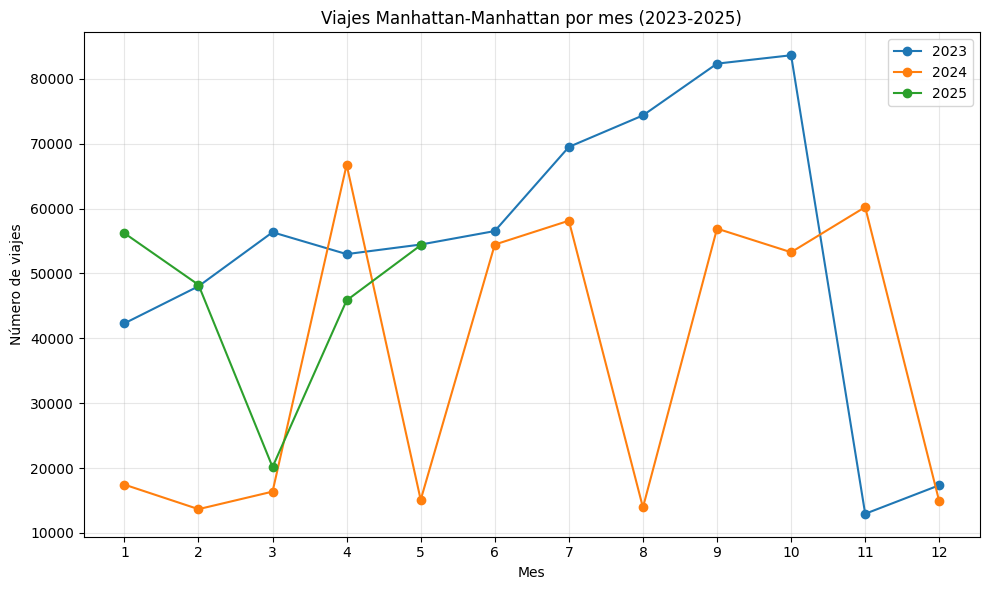

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for year in df_meses.columns:
    plt.plot(df_meses.index, df_meses[year], marker="o", label=year)

plt.title("Viajes Manhattan-Manhattan por mes (2023-2025)")
plt.xlabel("Mes")
plt.ylabel("Número de viajes")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

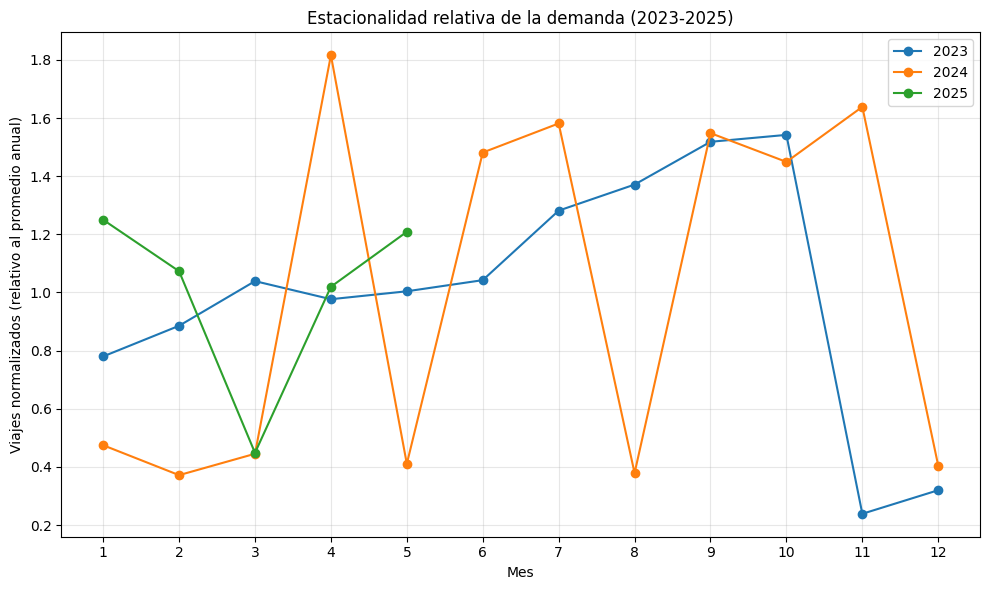

In [18]:
df_norm = df_meses.div(df_meses.mean())

plt.figure(figsize=(10,6))
for year in df_norm.columns:
    plt.plot(df_norm.index, df_norm[year], marker="o", label=year)

plt.title("Estacionalidad relativa de la demanda (2023-2025)")
plt.xlabel("Mes")
plt.ylabel("Viajes normalizados (relativo al promedio anual)")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

-----------------------------------------------------
-----------------------------------------------------

In [90]:
# Crear columna de semana del mes
df_all['week_of_month'] = df_all['pickup_datetime'].dt.day.apply(lambda d: (d - 1) // 7 + 1)
# Crear columna de hora
df_all['hour'] = df_all['pickup_datetime'].dt.hour

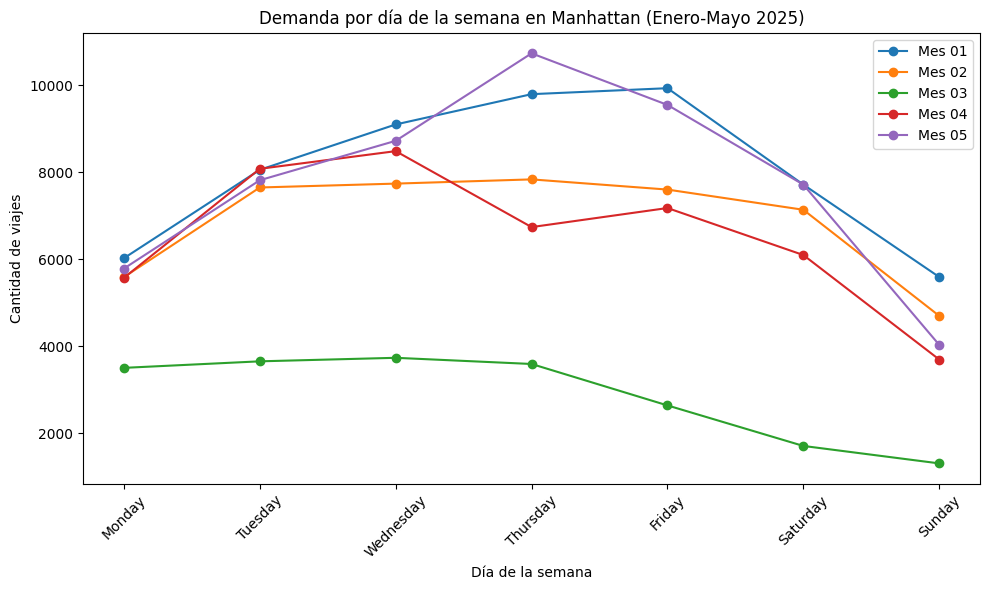

In [91]:
# Ordenar los días de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Graficar
plt.figure(figsize=(10,6))
for mes in sorted(demanda['month'].unique()):
    datos_mes = demanda[demanda['month'] == mes]
    datos_mes = datos_mes.set_index('weekday').reindex(dias_orden)
    plt.plot(dias_orden, datos_mes['count'], marker='o', label=f'Mes {mes:02d}')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de viajes')
plt.title('Demanda por día de la semana en Manhattan (Enero-Mayo 2025)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

¿Afecta la semana dentro del mes a los días con mayor o menor demanda?

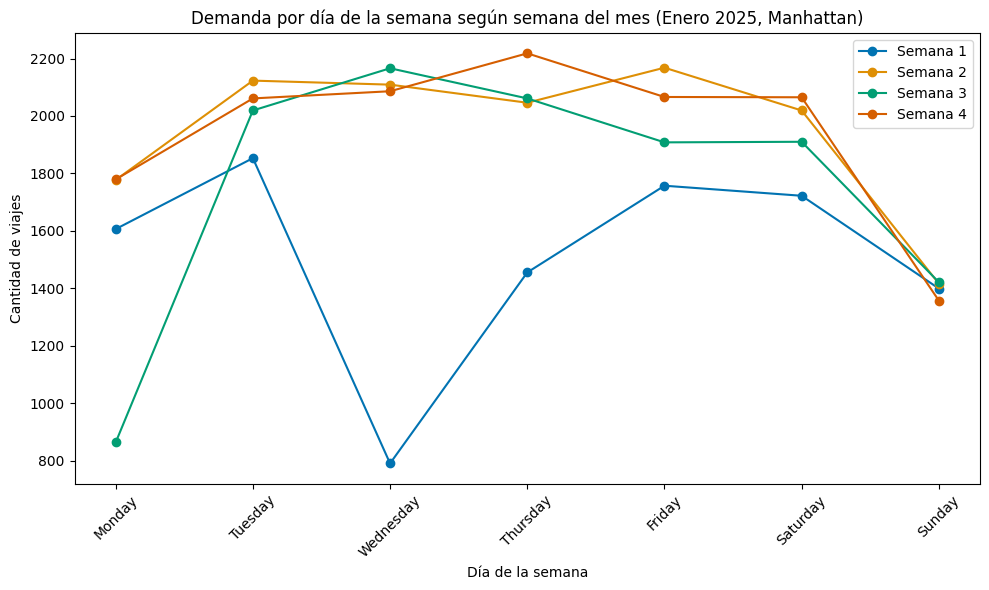

In [93]:
# Analizar si la semana dentro del mes afecta los días con mayor o menor demanda
mes_interes = 1
df_mes = df_all[df_all['month'] == mes_interes]

# Agrupar por semana del mes y día de la semana
demanda_semana_dia = df_mes.groupby(['week_of_month', 'weekday']).size().reset_index(name='count')

# Ordenar los días de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Seleccionar solo semanas 1 a 4
semanas_validas = [1, 2, 3, 4]
colores = sns.color_palette("colorblind", n_colors=len(semanas_validas))

plt.figure(figsize=(10,6))
for i, semana in enumerate(semanas_validas):
    datos_semana = demanda_semana_dia[demanda_semana_dia['week_of_month'] == semana]
    datos_semana = datos_semana.set_index('weekday').reindex(dias_orden)
    plt.plot(dias_orden, datos_semana['count'], marker='o', label=f'Semana {semana}', color=colores[i])
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de viajes')
plt.title('Demanda por día de la semana según semana del mes (Enero 2025, Manhattan)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Veamos para otro mes porque la primera semana de enero tiene feriado por año nuevo


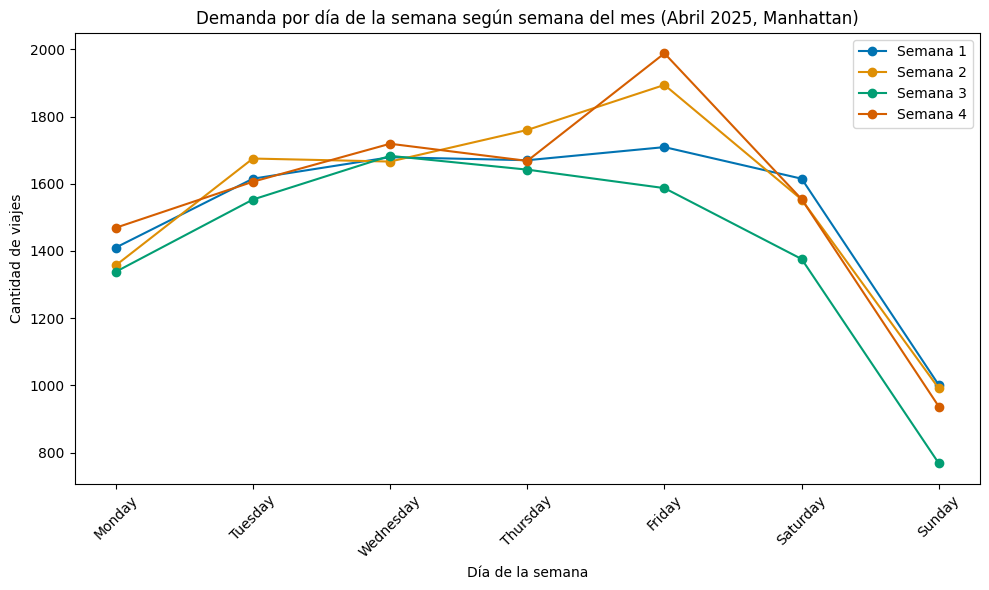

In [94]:
mes_interes = 4
df_mes = df_all[df_all['month'] == mes_interes]

# Agrupar por semana del mes y día de la semana
demanda_semana_dia = df_mes.groupby(['week_of_month', 'weekday']).size().reset_index(name='count')

# Ordenar los días de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Seleccionar solo semanas 1 a 4
semanas_validas = [1, 2, 3, 4]
colores = sns.color_palette("colorblind", n_colors=len(semanas_validas))

plt.figure(figsize=(10,6))
for i, semana in enumerate(semanas_validas):
    datos_semana = demanda_semana_dia[demanda_semana_dia['week_of_month'] == semana]
    datos_semana = datos_semana.set_index('weekday').reindex(dias_orden)
    plt.plot(dias_orden, datos_semana['count'], marker='o', label=f'Semana {semana}', color=colores[i])
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de viajes')
plt.title('Demanda por día de la semana según semana del mes (Abril 2025, Manhattan)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Estabilidad entre semanas:
- La forma del patrón es casi igual en las 4 semanas
- La dda es predecible semana a semana

Variabilidad Moderada:
- Semana 4 llega a cerca de 2.000 el viernes, mientras que la 3 con apenas llega a 1.600
- El patrón se repite, pero hay diferencis de escala entre semanas
- Esto justifica usar distribuciones de probabilidad y no solo un promedio determinista por ejemplo

Patró laboral claro:
- De lunes a viernes la dda se mantiene alta
- Viernes tiende a ser el pico máximo
- Fines de semana caen fuertemente
- Mayor parte de los viajes tienen motivos laborales/diarios

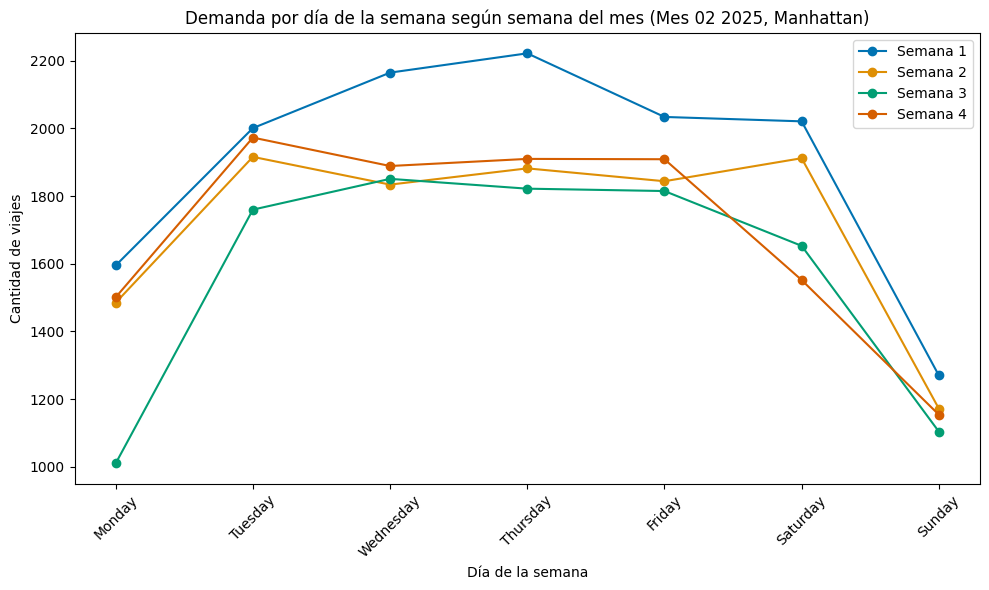

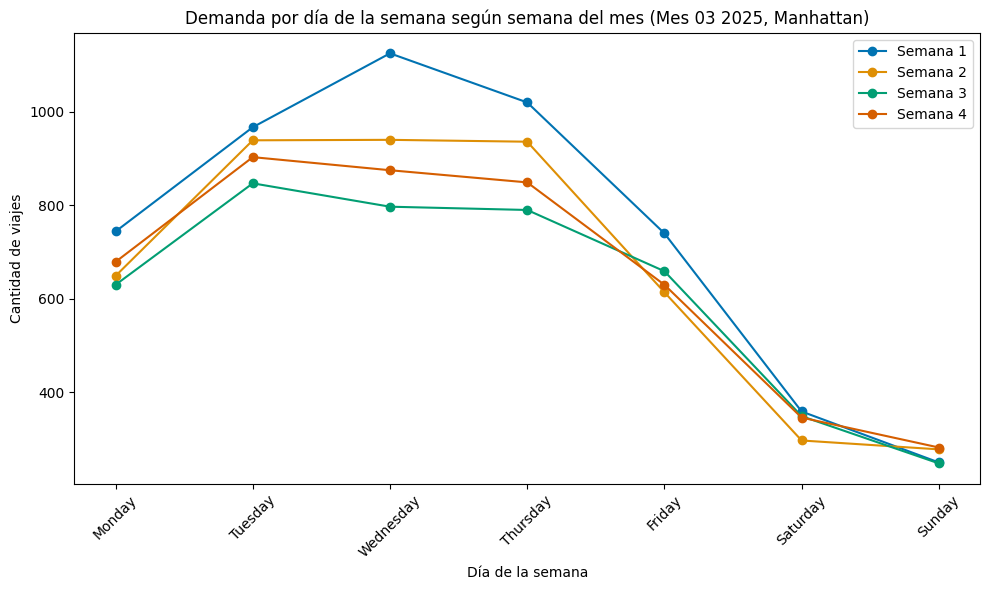

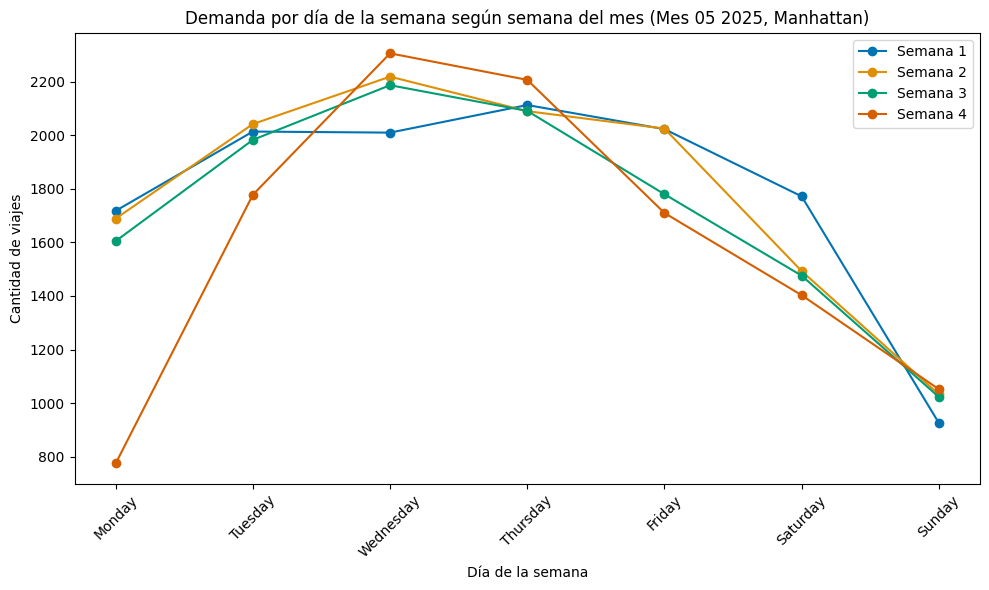

In [95]:
# Graficar demanda por día de la semana según semana del mes para los meses 2, 3 y 5

for mes_interes in [2, 3, 5]:
    df_mes = df_all[df_all['month'] == mes_interes]
    demanda_semana_dia = df_mes.groupby(['week_of_month', 'weekday']).size().reset_index(name='count')
    dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    semanas_validas = [1, 2, 3, 4]
    colores = sns.color_palette("colorblind", n_colors=len(semanas_validas))

    plt.figure(figsize=(10,6))
    for i, semana in enumerate(semanas_validas):
        datos_semana = demanda_semana_dia[demanda_semana_dia['week_of_month'] == semana]
        datos_semana = datos_semana.set_index('weekday').reindex(dias_orden)
        plt.plot(dias_orden, datos_semana['count'], marker='o', label=f'Semana {semana}', color=colores[i])
    plt.xlabel('Día de la semana')
    plt.ylabel('Cantidad de viajes')
    plt.title(f'Demanda por día de la semana según semana del mes (Mes {mes_interes:02d} 2025, Manhattan)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

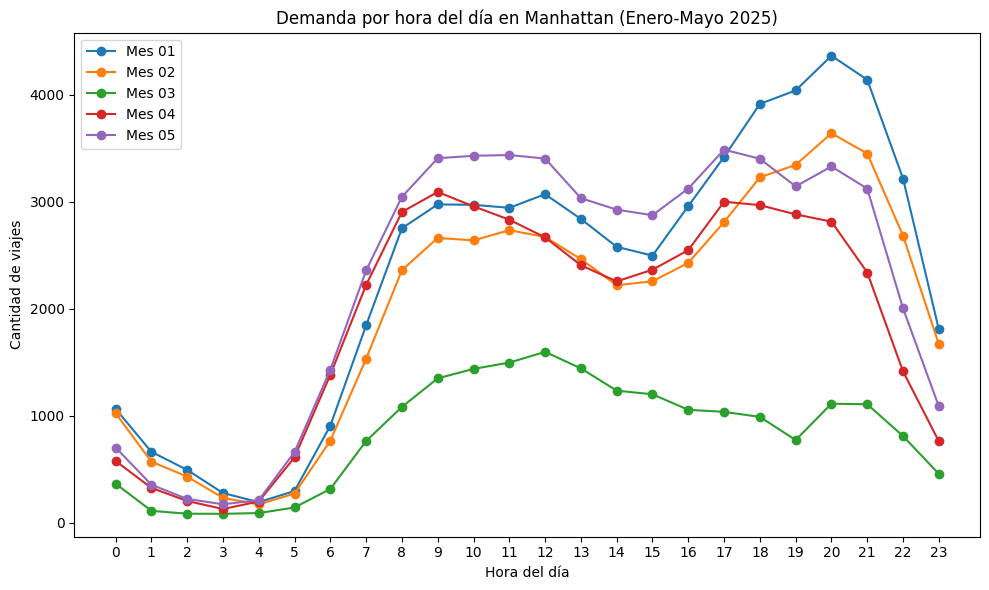

In [ ]:

# Analizar variación de la demanda según la hora del día

# Agrupar por mes y hora
demanda_hora = df_all.groupby(['month', 'hour']).size().reset_index(name='count')

# Graficar
plt.figure(figsize=(10,6))
for mes in sorted(demanda_hora['month'].unique()):
    datos_mes = demanda_hora[demanda_hora['month'] == mes]
    plt.plot(datos_mes['hour'], datos_mes['count'], marker='o', label=f'Mes {mes:02d}')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de viajes')
plt.title('Demanda por hora del día en Manhattan (Enero-Mayo 2025)')
plt.legend()
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

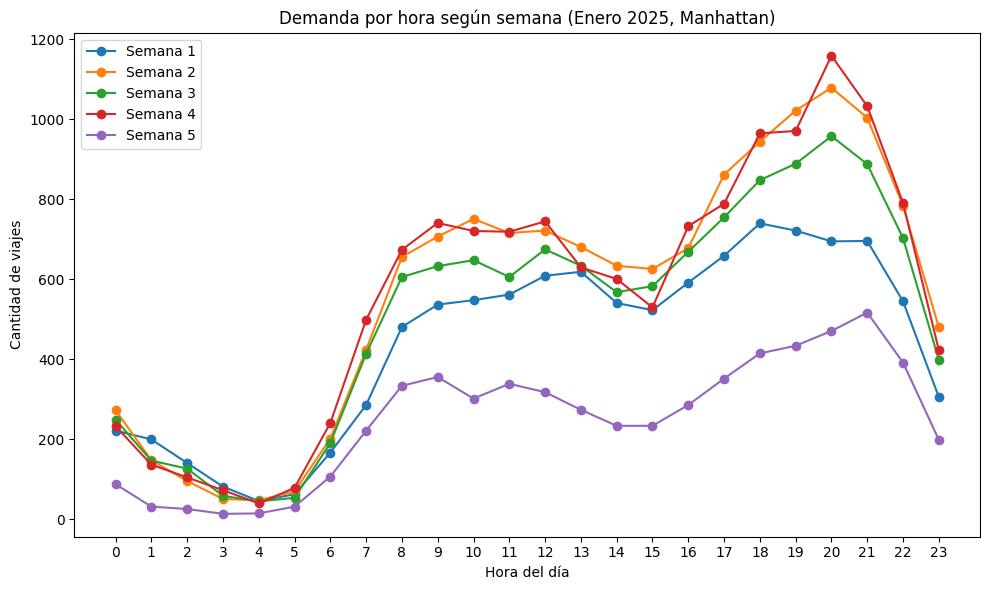

In [96]:
# Filtrar solo el mes 1 (enero)
df_mes1 = df_all[df_all['month'] == 1]

# Agrupar por semana del mes y hora
demanda_semana_hora = df_mes1.groupby(['week_of_month', 'hour']).size().reset_index(name='count')

# Graficar
plt.figure(figsize=(10,6))
for semana in sorted(demanda_semana_hora['week_of_month'].unique()):
    datos_semana = demanda_semana_hora[demanda_semana_hora['week_of_month'] == semana]
    plt.plot(datos_semana['hour'], datos_semana['count'], marker='o', label=f'Semana {semana}')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de viajes')
plt.title('Demanda por hora según semana (Enero 2025, Manhattan)')
plt.legend()
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()